# Analysis
The key variable to judge success of offers and dependent variable for predictive modeling is incremental spend.
Other variables were considered, such as:
* Offer completion - will be looked at in the descriptives. Offer completion is a good proxy for how attractive consumers find an offer. However, from a business perspoective it is not as relevant as incremental spend, because it is possible that offers influence spend even when a consumer does not complete the offer. In addition, there is no offer completion for purely informational offers.
* Average hourly spend - A metric that considers the behavioural change (likely increase/potentially decrease in spend by the hour) during awareness. This can be compared to times when a consumer is not aware of any offer. As this metric does not factor in for *how long* a consumer sustains a higher level of spend, it does not tell the business what revenue it can make from an offer, though.
* Net total/incremental spend - A way to understand the net impact on the business better by deducting the reward amount from the total spend. However, this is a potentially poor proxy. For BOGO, it is unlikely that the consumer would have purchased two of the same product, and the cost to the company is hence not the revenue foregone, but the actual production cost of the product. In comparison, for the discount, the cost is the actual revenue foregone. There might also be other costs associated with the offers, like e.g. distribution cost. As costs are unknown, it was decided to work with incremental revenue.

These variables are contained in the analysis_df in case one wants to explore these variables further.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import json
import os
import pylab
import itertools
#% matplotlib inline
from pandasql import sqldf
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import statsmodels.api as sm

## Read in data and do basic data manipulation and cleaning

#### Read in data

In [2]:
# Read in the file
analysis_df = pd.read_csv(r'2021_12_27_analysis_df.csv')

C:\Users\j\Python\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (2,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
analysis_df

,Unnamed: 0,person,block_id,hour,amount,hourly_avg,group,baseline_spend_during_awareness_time,incremental_spend,hourly_avg_during_nonawareness,...,time_lag_completion,time_lag_completion_to_expiry,gender,age,id,became_member_on,income,membership_duration,net_spend,net_spend_hourly_avg
0,0,68be06ca386d4c31939f3a4f0e3dd783,no_offer,231.0,0.00,0.000000,c,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,-1785,0.00,0.000000
1,1,0610b486422d4921ae7d2bf64640c50b,no_offer,714.0,77.01,0.107857,c,NaN,NaN,NaN,...,NaN,NaN,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,-1632,77.01,0.107857
2,2,38fe809add3b4fcf9315a9694bb96ff5,no_offer,545.0,14.30,0.026239,c,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,-1270,14.30,0.026239
3,3,78afa995795e4d85b5d9ceeca43f5fef,no_offer,459.0,68.27,0.148736,c,NaN,NaN,NaN,...,NaN,NaN,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,-1699,68.27,0.148736
4,4,a03223e636434f42ac4c3df47e8bac43,no_offer,291.0,3.56,0.012234,c,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,-1612,3.56,0.012234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66442,66442,fffad4f4828548d1b5583907f2e9906b,76614,31.0,6.97,0.224839,t,3.292786,3.677214,0.106219,...,30.0,84.0,M,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,1.97,0.063548
66443,66443,fffad4f4828548d1b5583907f2e9906b,76615,7.0,12.18,1.740000,t,0.743532,11.436468,0.106219,...,6.0,12.0,M,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,7.18,1.025714
66444,66444,ffff82501cea40309d5fdd7edcca4a07,76616,25.0,22.88,0.915200,t,7.112769,15.767231,0.284511,...,24.0,210.0,F,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,17.88,0.715200
66445,66445,ffff82501cea40309d5fdd7edcca4a07,76617,31.0,15.57,0.502258,t,8.819834,6.750166,0.284511,...,30.0,120.0,F,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,13.57,0.437742


#### Create better identifier for offers in order to make graphs more meaningful

In [5]:
# Create a variable that identifies offers and gives some descriptive context:
# type_difficulty_reward_#channels
event_descriptor_dict = {'ae264e3637204a6fb9bb56bc8210ddfd':'bogo_10_10_3',
                        '0b1e1539f2cc45b7b9fa7c272da2e1d7':'disc_20_5_2',
                        '5a8bc65990b245e5a138643cd4eb9837':'info_0_0_2',
                        '3f207df678b143eea3cee63160fa8bed':'info_0_0_4',
                        '4d5c57ea9a6940dd891ad53e9dbe8da0':'bogo_10_10_4',
                        'f19421c1d4aa40978ebb69ca19b0e20d':'bogo_5_5_4',
                        'fafdcd668e3743c1bb461111dcafc2a4':'disc_10_2_4',
                        '2298d6c36e964ae4a3e7e9706d1fb8c2':'disc_7_3_4',
                        '2906b810c7d4411798c6938adc9daaa5':'disc_10_2_3',
                        '9b98b8c7a33c4b65b9aebfe6a799e6d9':'bogo_5_5_3'}

analysis_df['offer_descriptor'] = analysis_df['event_offer_id'].map(event_descriptor_dict)

In [6]:
# Create a pure treatment dataframe
analysis_df_t = analysis_df.loc[analysis_df['group'] == 't']

In [7]:
analysis_df_t

,Unnamed: 0,person,block_id,hour,amount,hourly_avg,group,baseline_spend_during_awareness_time,incremental_spend,hourly_avg_during_nonawareness,...,time_lag_completion_to_expiry,gender,age,id,became_member_on,income,membership_duration,net_spend,net_spend_hourly_avg,offer_descriptor
17000,17000,0009655768c64bdeb2e877511632db8f,1,61.0,8.570,0.140492,t,9.783228,-1.213228,0.160381,...,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,-1717,8.570,0.140492,info_0_0_4
17001,17001,0009655768c64bdeb2e877511632db8f,2,49.0,22.160,0.452245,t,7.858659,14.301341,0.160381,...,NaN,M,33.0,0009655768c64bdeb2e877511632db8f,2017-04-21,72000.0,-1717,22.160,0.452245,info_0_0_2
17002,17002,00116118485d4dfda04fdbaba9a87b5c,5,73.0,0.000,0.000000,t,0.520157,-0.520157,0.007125,...,NaN,NaN,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,-1348,0.000,0.000000,bogo_5_5_4
17003,17003,00116118485d4dfda04fdbaba9a87b5c,6,67.0,0.000,0.000000,t,0.477404,-0.477404,0.007125,...,NaN,NaN,NaN,00116118485d4dfda04fdbaba9a87b5c,2018-04-25,NaN,-1348,0.000,0.000000,bogo_5_5_4
17004,17004,0011e0d4e6b944f998e987f904e8c1e5,7,145.0,11.025,0.076034,t,18.524157,-7.499157,0.127753,...,72.0,O,40.0,0011e0d4e6b944f998e987f904e8c1e5,2018-01-09,57000.0,-1454,6.025,0.041552,disc_20_5_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66442,66442,fffad4f4828548d1b5583907f2e9906b,76614,31.0,6.970,0.224839,t,3.292786,3.677214,0.106219,...,84.0,M,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,1.970,0.063548,bogo_5_5_4
66443,66443,fffad4f4828548d1b5583907f2e9906b,76615,7.0,12.180,1.740000,t,0.743532,11.436468,0.106219,...,12.0,M,34.0,fffad4f4828548d1b5583907f2e9906b,2017-01-23,34000.0,-1805,7.180,1.025714,bogo_5_5_4
66444,66444,ffff82501cea40309d5fdd7edcca4a07,76616,25.0,22.880,0.915200,t,7.112769,15.767231,0.284511,...,210.0,F,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,17.880,0.715200,disc_20_5_2
66445,66445,ffff82501cea40309d5fdd7edcca4a07,76617,31.0,15.570,0.502258,t,8.819834,6.750166,0.284511,...,120.0,F,45.0,ffff82501cea40309d5fdd7edcca4a07,2016-11-25,62000.0,-1864,13.570,0.437742,disc_10_2_3


#### Remove all awareness period where the offer was not completed or did not expire during the analysis timeframe

In [8]:
analysis_df_t.dtypes

Unnamed: 0                                int64
person                                   object
block_id                                 object
hour                                    float64
amount                                  float64
hourly_avg                              float64
group                                    object
baseline_spend_during_awareness_time    float64
incremental_spend                       float64
hourly_avg_during_nonawareness          float64
event_offer_id                           object
offer received                          float64
offer viewed                            float64
offer completed                         float64
event_reward                            float64
offer_type                               object
offer_reward                            float64
offer_duration                          float64
offer_valid_until                       float64
offer_difficulty                        float64
email                                   

In [9]:
analysis_df_t['offer_valid_until_exceeding_experiment'] = analysis_df_t['offer_duration'] + analysis_df_t['offer received']

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
# Remove offers where the outcome is unclear at the end of the experiment
analysis_df_t = analysis_df_t.loc[analysis_df_t['offer_valid_until_exceeding_experiment'] <= transcript['time'].max()]

#### Remove outliers of incremental spend
Rationale: Some respondents have oddly high values in transaction records. Potentially, they bought for a large group of people, or it is a data entry error. These records can lead to very high or very low incremental spend. They will heavily bias averages and need to be removed. 
* The **histogram** below shows the distribution of very high and very low values to get a feeling for the magnitudes. 
* The **Q-Q plot** shows that the data is not normally distributed (it is " too narrow", i.e. it has lower variance than a normal distribution) and hence the way to remove outliers should be using the IQR (see: Jason Brownlee on April 25, 2018 in Data Preparation - How to Remove Outliers for Machine Learning - Machine Learning Matery: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/) 
* The **boxplot** shows that the extreme values are largely considered outliers when using a IQR removal approach (see section *whis* for definition here: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html)

Using the usual 1.5 * IQR approach, 7.7% of the sample are removed as outliers. This is a rather high value, considering that when using the Standard Deviation method, between 2 and 4 standard deviations are used to define outliers, hence leading to a data loss of max. 5%. The factor by which the IQR is multiplied was hence increased to 3, which means that 2.34% of the data was classified as outliers. The cut-offs still seem high, but possible at -37 and 48.

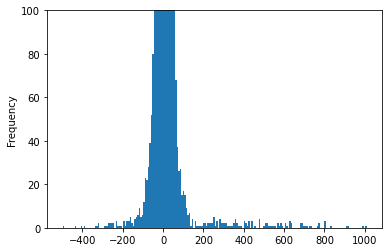

In [11]:
# Source Stackkoverflow: https://stackoverflow.com/questions/38424459/set-y-axis-limit-in-pandas-histogram
# Question by Andy Toulis: https://stackoverflow.com/users/6369225/andy-toulis
# Answer by Martin Thoma: https://stackoverflow.com/users/562769/martin-thoma
analysis_df_t['incremental_spend'].plot.hist(ylim=(0,100), bins = 200);

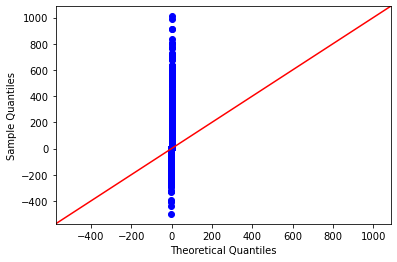

In [12]:
# Normal distribution? Q-Q plot
sm.qqplot(analysis_df_t['incremental_spend'], line = '45')
pylab.show()

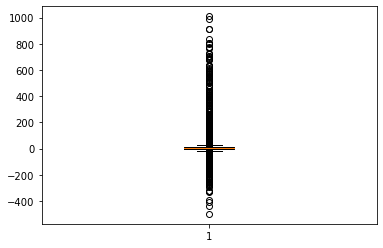

In [13]:
# Outliers ("flyers") in the data
plt.boxplot(analysis_df_t['incremental_spend']);

In [14]:
# Removing the outliers
# Source: Jason Brownlee on April 25, 2018 in Data Preparation - How to Remove Outliers for Machine Learning - Machine Learning Matery: https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

q25 = np.percentile(analysis_df_t['incremental_spend'], 25)
q75 = np.percentile(analysis_df_t['incremental_spend'], 75)
iqr = q75 - q25
cut_off = iqr * 3
bottom_cut_off = q25 - cut_off
top_cut_off = q75 + cut_off
print("bottom cut off is: ", bottom_cut_off)
print("top cut off is: ", top_cut_off)

bottom cut off is:  -37.504245705101184
top cut off is:  47.806031935075886


In [15]:
analysis_df_t['outlier'] = 0
analysis_df_t.loc[(analysis_df_t['incremental_spend'] < bottom_cut_off) | (analysis_df_t['incremental_spend'] > top_cut_off), 'outlier'] = 1

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\j\Python\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [16]:
# Check number of outliers
analysis_df_t['outlier'].value_counts()

0    42571
1     1046
Name: outlier, dtype: int64

In [17]:
# Create df without outliers
analysis_df_t = analysis_df_t.loc[analysis_df_t['outlier'] == 0]

#### Inspect disctirbutions
Overall, a spike at 0 is visible in the overall distribution as well as sub-samples for the informational offer and non-completed bogo and discount.
The distribution of completed offers shows that there are offers where the customer spent more than the difficulty of the offer was. Investigation shows that these are BOGO offers where the customer in *total* spent more than the required amount to complete the offer, but didn't spend this money in one go. THis is why the offer wasn't triggered.



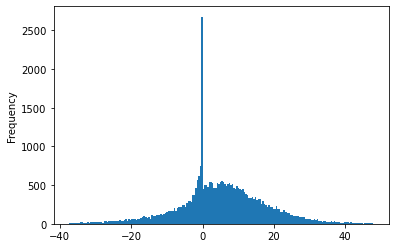

In [136]:
# Look at distribution after removing outliers
analysis_df_t['incremental_spend'].plot.hist(bins = 200);

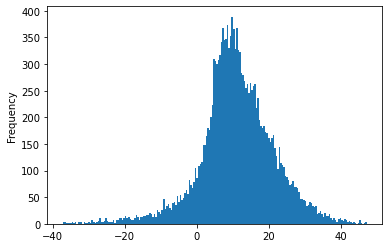

In [137]:
# Look at distribution for those who complete the offer
analysis_df_t.loc[analysis_df_t['was_completed'] == 1]['incremental_spend'].plot.hist(bins = 200);

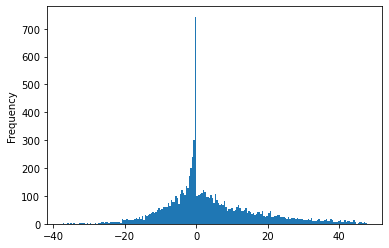

In [164]:
analysis_df_t.loc[(analysis_df_t['offer_type']=='informational')]['incremental_spend'].plot.hist(bins = 200);

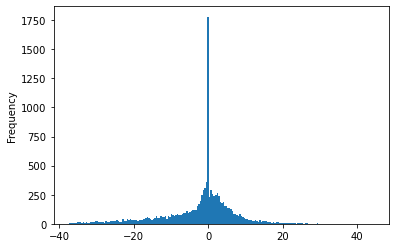

In [140]:
# Look at distribution for those who did not complete the offer and did not receive an advertisement
analysis_df_t.loc[(analysis_df_t['was_completed'] == 0) & (analysis_df_t['offer_type']!='informational')]['incremental_spend'].plot.hist(bins = 200);

## Descriptive Analyses
**Completion:** Based on the descriptive statistics below show, discounts get completed more frequently than BOGO offers. 

**Incremental spend:** Despite discounts being completed more often, it is a BOGO offer (difficulty 10, reward 10, channels 3) that, on average, has the highest incremental spend. Maybe surprisingly, both informational offers show a high average incremental spend, too. When looking at distributions for informational offers, the spikes around the origin show that many customers do not change their spend as compared to non-offer-aware times, however. In comparison, for BOGO and discounts, one can spot spikes in the distribution at the value of difficulty (i.e. the money the customer needs to spend to complete the offer).

**Completion and incremental spend:** It could be possible that simple awareness already leads to positive incremental spend. This is not the case. The data shows that only completed offers are, on average, associated with higher incremental spend. One could therefore argue that the company should try to only target consumers that are likely to complete an offer. If the company was successful in this targeting and 100% of those who receive the offer and are aware complete it, then the best offer for the company would be another one - quite logically one with high difficulty (discount, difficulty 10, reward 5, channels 2). 

**Further analysis:**
As there will be an unknown costs associated with an offer, the predictive modeling analysis analysis will be using incremental spend of all who were aware of the offer as dependent variable rather than offer completion. This will allow the company to see who is worth targeting and give the company the flexibility to adjust monetary thresholds of when a person will be sent an offer flexibly and based on cost. By using this logic, the company is likely to automatically pick people who are likely to complete the offer.

#### Check base sizes
to assure that for each group I am interested in, base sizes are large enough to draw conclusions

In [18]:
pd.DataFrame(analysis_df_t.groupby(['offer_type']).size())

,0
offer_type,
bogo,19627
discount,13543
informational,9401


In [19]:
pd.DataFrame(analysis_df_t.groupby(['offer_descriptor']).size())

,0
offer_descriptor,
bogo_10_10_3,4691
bogo_10_10_4,6288
bogo_5_5_3,2659
bogo_5_5_4,5989
disc_10_2_3,2738
disc_10_2_4,4150
disc_20_5_2,1553
disc_7_3_4,5102
info_0_0_2,5816


#### Understand offer completion
as an indicator for how attractive a BOGO and discount offer are to consumers.
Consumers do more often complete the discount than the BOGO offers.

In [20]:
analysis_df_t[['offer_type','was_completed']].groupby(['offer_type']).mean()

,was_completed
offer_type,
bogo,0.442656
discount,0.637525
informational,0.000000


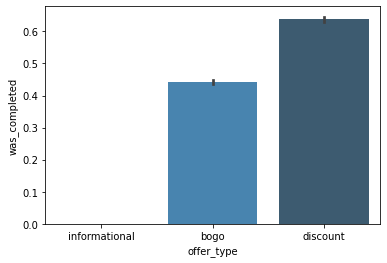

In [21]:
# How often do offers get completed (note: completion is not defined for informational offers)?
sns.barplot(x = analysis_df_t['offer_type'], y = analysis_df_t['was_completed'], palette="Blues_d");

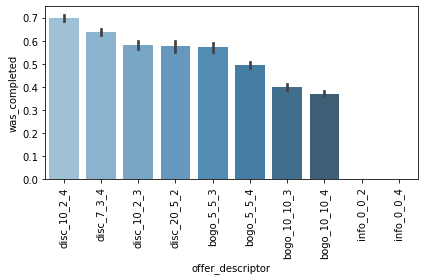

In [22]:
# Source Stackoverflow: https://stackoverflow.com/questions/31859285/rotate-tick-labels-for-seaborn-barplot
# Question by Laurennmc: https://stackoverflow.com/users/5198702/laurennmc
# Answer by wordsforthewise: https://stackoverflow.com/users/4549682/wordsforthewise

# Source for ordering is Stackoverflow: https://stackoverflow.com/questions/43770507/seaborn-bar-plot-ordering
# Question by vladkras: https://stackoverflow.com/users/1713660/vladkras
# Answer by Jeremy: https://stackoverflow.com/users/674301/jeremy

grp_order = analysis_df_t.groupby('offer_descriptor').was_completed.agg('mean').sort_values(ascending = False).index
sns.barplot(x = analysis_df_t['offer_descriptor'], y = analysis_df_t['was_completed'], order=grp_order, palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout();

#### Understand incremental spend
to assess which offer type has the biggest impact on business revenue.
When plotting distributions, the graphs for BOGO and discount exhibit peaks at the difficulty level, i.e. the amount of money that needs to be spent to complete the offer. For informational offers, the graphs show more extreme maxima at/close to the origin, showing that many respondents did not change their behaviour as a consequency of the advertisement.

In [23]:
# Incremental spend
pd.DataFrame(analysis_df_t.groupby(['offer_descriptor','offer_type','offer_difficulty', 'offer_reward', 'email', 'mobile','social','web']).agg({'incremental_spend':[np.mean, np.median]}).reset_index().sort_values(by=[('incremental_spend','mean')], ascending = False))

offer_descriptor     offer_type offer_difficulty offer_reward email mobile  \
                                                                               
6      disc_20_5_2       discount             20.0          5.0   1.0    0.0   
5      disc_10_2_4       discount             10.0          2.0   1.0    1.0   
0     bogo_10_10_3           bogo             10.0         10.0   1.0    1.0   
7       disc_7_3_4       discount              7.0          3.0   1.0    1.0   
1     bogo_10_10_4           bogo             10.0         10.0   1.0    1.0   
4      disc_10_2_3       discount             10.0          2.0   1.0    1.0   
2       bogo_5_5_3           bogo              5.0          5.0   1.0    1.0   
3       bogo_5_5_4           bogo              5.0          5.0   1.0    1.0   
8       info_0_0_2  informational              0.0          0.0   1.0    1.0   
9       info_0_0_4  informational              0.0          0.0   1.0    1.0   

  social  web incremental_spend            
                           mean    median  
6    0.0  1.0          7.371040  5.736856  
5    1.0  1.0          6.297533  6.475318  
0    1.0  0.0          5.442909  4.638487  
7    1.0  1.0          4.855819  4.739789  
1    1.0  1.0          4.716083  3.138796  
4    0.0  1.0          4.675288  4.518141  
2    0.0  1.0          4.152968  3.730000  
3    1.0  1.0          4.047608  3.085326  
8    1.0  0.0          3.581101  0.000000  
9    0.0  1.0          3.085520  0.000000

In [24]:
# Charting distributions of incremental spend
b1 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_10_10_3']['incremental_spend']
b2 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_10_10_4']['incremental_spend']
b3 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_5_5_3']['incremental_spend']
b4 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'bogo_5_5_4']['incremental_spend']
d1 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_20_5_2']['incremental_spend']
d2 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_10_2_4']['incremental_spend']
d3 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_10_2_3']['incremental_spend']
d4 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'disc_7_3_4']['incremental_spend']
i1 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'info_0_0_2']['incremental_spend']
i2 = analysis_df_t.loc[analysis_df_t['offer_descriptor'] == 'info_0_0_4']['incremental_spend']

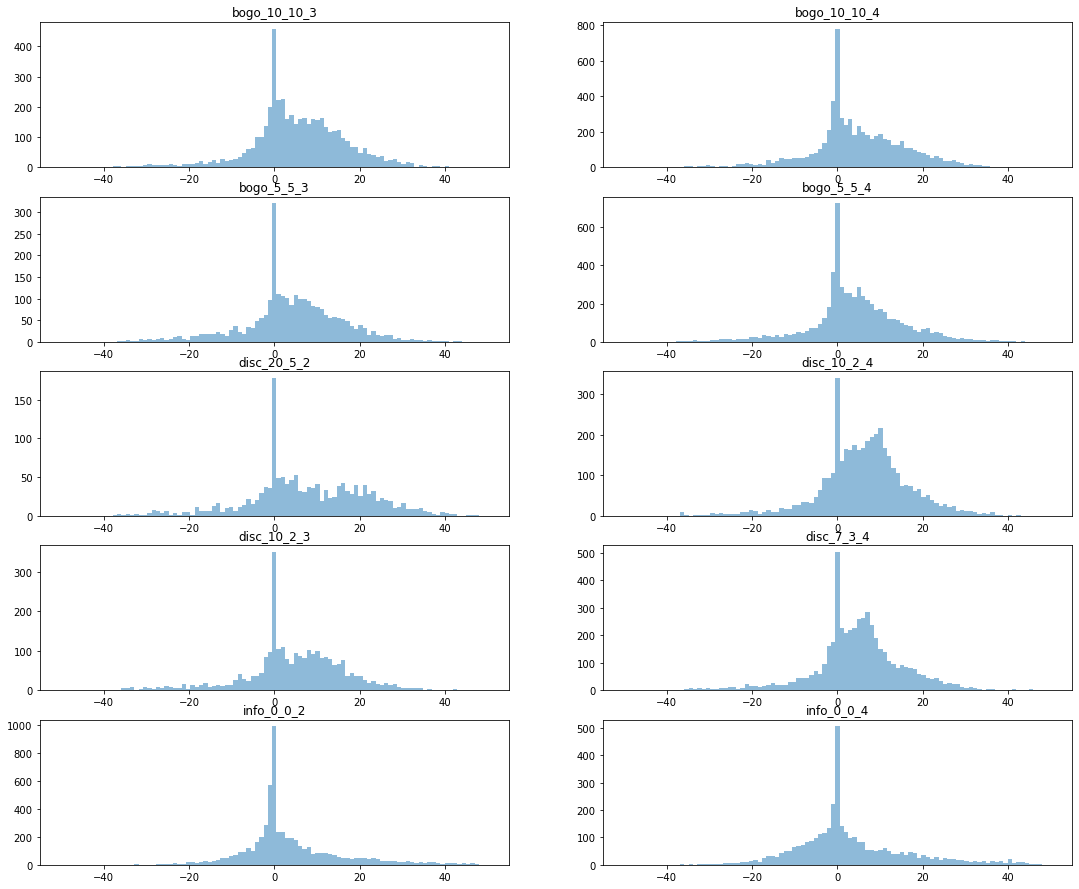

In [25]:
bins = np.linspace(-50, 50, 100)

fig, axs = plt.subplots(5,2) #,sharex=True, sharey=True)
fig.set_size_inches(18.5, 15.5)
ax_b1 = axs[0, 0].hist(b1, bins, alpha=0.5, label='bogo_10_10_3')
axs[0, 0].set_title('bogo_10_10_3')
ax_b2 = axs[0, 1].hist(b2, bins, alpha=0.5, label='bogo_10_10_4')
axs[0, 1].set_title('bogo_10_10_4')
ax_b3 = axs[1, 0].hist(b3, bins, alpha=0.5, label='bogo_5_5_3')
axs[1, 0].set_title('bogo_5_5_3')
ax_b4 = axs[1, 1].hist(b4, bins, alpha=0.5, label='bogo_5_5_4')
axs[1, 1].set_title('bogo_5_5_4')

ax_d1 = axs[2, 0].hist(d1, bins, alpha=0.5, label='disc_20_5_2')
axs[2, 0].set_title('disc_20_5_2')
ax_d2 = axs[2, 1].hist(d2, bins, alpha=0.5, label='disc_10_2_4')
axs[2, 1].set_title('disc_10_2_4')
ax_d3 = axs[3, 0].hist(d3, bins, alpha=0.5, label='disc_10_2_3')
axs[3, 0].set_title('disc_10_2_3')
ax_d4 = axs[3, 1].hist(d4, bins, alpha=0.5, label='disc_7_3_4')
axs[3, 1].set_title('disc_7_3_4')

ax_i1 = axs[4, 0].hist(i1, bins, alpha=0.5, label='info_0_0_2')
axs[4, 0].set_title('info_0_0_2')
ax_i2 = axs[4, 1].hist(i2, bins, alpha=0.5, label='info_0_0_4')
axs[4, 1].set_title('info_0_0_4');

#### Understand the impact of completion on incremental spend
to assess if simply knowing about an offer already leads to higher spend.
This is not the case. Average incremental spend is negative for those who do not complete the offer, meaning that these people spend less than they do when they are not aware of any offers.

If the company was better at targeting those who will complete an offer, the incremental spend would be best for the discount at difficulty 20 and reward 5.

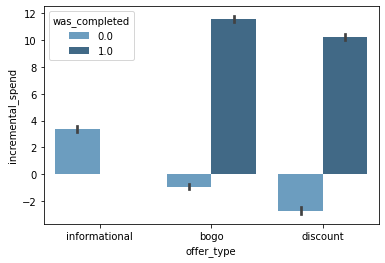

In [26]:
# Does only being aware of an offer w/o completing it also lead to positive incremental spend
sns.barplot(x = analysis_df_t['offer_type'], y = analysis_df_t['incremental_spend'], hue = analysis_df_t['was_completed'], palette="Blues_d");

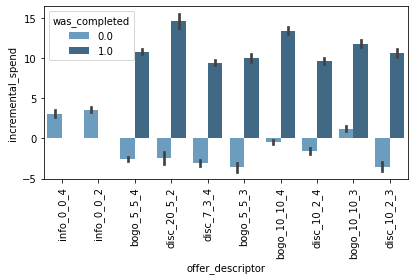

In [27]:
sns.barplot(x = analysis_df_t['offer_descriptor'], y = analysis_df_t['incremental_spend'], hue = analysis_df_t['was_completed'], palette="Blues_d")
plt.xticks(rotation=90)
plt.tight_layout();

## Finding the most successful offers
The data for the 10 offers is not normally distributed, as can easily be seen from the spikes at 0. Therefore, a non-parametric test needs to be used to establish if the offer success, measured as incremental spend, differs between offers. The Kruskal-Wallis test is the non-parametric counterpart to a one-way ANOVA. It assesses if the medians of two or more groups are statistically significantly different from each other. A group in this case is defined by the offer, hence there are ten groups.

The Kruskal-Wallis test assumes that the groups are independent. The alternative where groups are not independent is the Friedman test. It can be argued that the groups in this data are neither truly dependent nor truly independent, because some respondents might be in various offer groups, whilst others won't. Therefore, this assumption of the Kruskal-Wallis test is partially violated. However, there is no test for the "mixed" scenario. Therefore the test is still used as best option. 

Sources: 
Richard A. Armstrong and Anthony C. Hilton, Nonparametric Analysis of Variance, 12 November 2010, https://onlinelibrary.wiley.com/doi/10.1002/9780470905173.ch24
No author, Kruskal-Wallis H Test using SPSS Statistics, no date, https://statistics.laerd.com/spss-tutorials/kruskal-wallis-h-test-using-spss-statistics.php

#### Visual inspection of medians

In [28]:
# Look at medians
print("b1 median: ",b1.median())
print("b2 median: ",b2.median())
print("b3 median: ",b3.median())
print("b4 median: ",b4.median())
print("d1 median: ",d1.median())
print("d2 median: ",d2.median())
print("d3 median: ",d3.median())
print("d4 median: ",d4.median())
print("i1 median: ",i1.median())
print("i2 median: ",i2.median())

b1 median:  4.638486842105264
b2 median:  3.1387956204379566
b3 median:  3.73
b4 median:  3.0853260869565218
d1 median:  5.736855670103093
d2 median:  6.475317585026888
d3 median:  4.5181410758414255
d4 median:  4.7397891566265065
i1 median:  0.0
i2 median:  0.0


#### Create arrays to feed into test

In [29]:
def make_array(s):
    '''
    Takes in a series and outputs as array
    '''
    array = s[~s.isna()].to_numpy()
    return array

In [30]:
b1 = make_array(b1)
b2 = make_array(b2)
b3 = make_array(b3)
b4 = make_array(b4)
d1 = make_array(d1)
d2 = make_array(d2)
d3 = make_array(d3)
d4 = make_array(d4)
i1 = make_array(i1)
i2 = make_array(i2)

#### Kruskal-Wallis test
to see if there are any differences between groups. p < 0.05, hence there are differences.

In [31]:
statistic, p_value = stats.kruskal(b1, b2, b3, b4, d1, d2, d3, d4, i1, i2)

In [32]:
print("F: ",statistic)
print("p: ",p_value)

F:  913.8614846235372
p:  6.377700634620933e-191


#### Post hoc test with Mann-Whitney U test and Bonferroni adjustment
to see between which offers these significant differences exist at alpha = 0.05. To account for multiple testing, alpha is Bonferroni-adjusted.
The **two** "top offers" are d1 and d2, which are not statistically significantly different from each other. So are a few other offer combinations. 

In [33]:
all_arrays = {"b1":b1, "b2":b2, "b3":b3, "b4":b4, "d1":d1, "d2":d2, "d3":d3, "d4":d4, "i1":i1, "i2":i1}

In [34]:
# Create all pairs that are needed
# Source Stackoverflow: https://stackoverflow.com/questions/11905573/getting-all-combinations-of-key-value-pairs-in-python-dict
# Question by Andrew C: https://stackoverflow.com/users/1335244/andrew-c
# Answer by Jolly Jumper: https://stackoverflow.com/users/1590392/jolly-jumper
pairs = list(map(dict, itertools.combinations(all_arrays.items(), 2)))

In [35]:
results_sig_diff = {}
results_not_sig_diff = {}
for i in pairs:
    combo = list(i)
    a = list(i)[0]
    b = list(i)[1]
    statistic, pvalue = stats.mannwhitneyu(i[a],i[b])
    # keeping those pairs that are statistically significalntly different using Bonferroni adjustment
    if pvalue < 0.05/len(pairs):
        results_sig_diff[str(a)+'_'+str(b)] = pvalue
    else:
        results_not_sig_diff[str(a)+'_'+str(b)] = pvalue

In [36]:
results_not_sig_diff

{'b1_d3': 0.029775519967164685,
 'b1_d4': 0.021961062057059385,
 'b2_b3': 0.38666680205957976,
 'b2_b4': 0.006674248818760421,
 'b2_d3': 0.02482836259350674,
 'b3_b4': 0.03555384295150148,
 'b3_d3': 0.024003621303899624,
 'b3_d4': 0.0035019301230954755,
 'd1_d2': 0.025463396764140254,
 'd3_d4': 0.45367789566043565,
 'i1_i2': 0.49999889832564903}

## Examining incremental spend and completion by offer characteristics
The below charts have to be interpreted very carefully. This is because the data does not contain every possible combination of offer attributes and types. For example: the reward of 10 looks like it should be a lot more attractive. However, it only comes with a BOGO offer. It is unknown how well such a reward would be received with a discount offer. Similarly, it looks like mobile is not a good way to advertise. However, there is only one offer without mobile advertisement, and this happens to be the one with the highest mean incremental spend. One cannot conclude that it is the lack of mobile advertisement that makes this offer more successful, when there are other factors, e.g. it being the only discount at amount 20, that could be the driver.

''

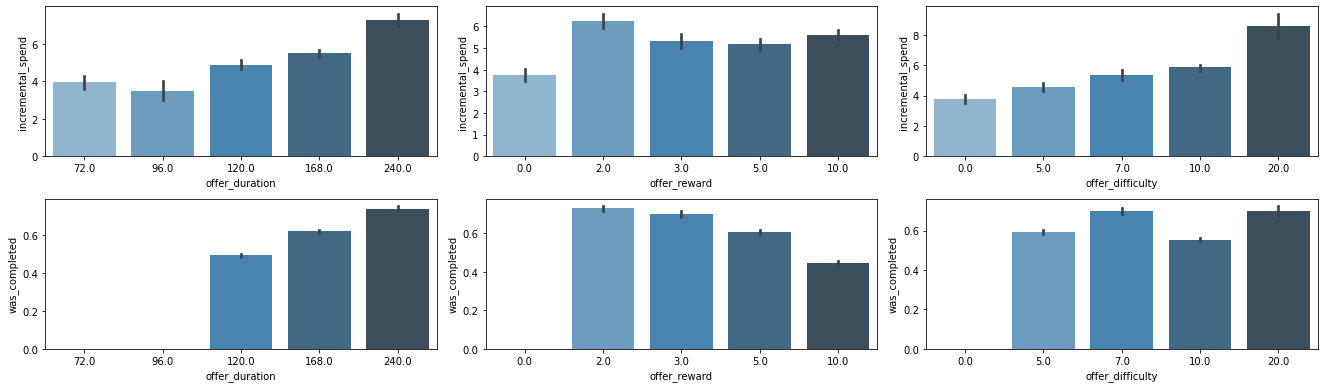

In [90]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(18.5, 5.5)
sns.barplot(ax=axs[0,0], x = analysis_df_t['offer_duration'], y = analysis_df_t['incremental_spend'], palette="Blues_d")
sns.barplot(ax=axs[0,1], x = analysis_df_t['offer_reward'], y = analysis_df_t['incremental_spend'], palette="Blues_d")
sns.barplot(ax=axs[0,2], x = analysis_df_t['offer_difficulty'], y = analysis_df_t['incremental_spend'], palette="Blues_d")
sns.barplot(ax=axs[1,0], x = analysis_df_t['offer_duration'], y = analysis_df_t['was_completed'], palette="Blues_d")
sns.barplot(ax=axs[1,1], x = analysis_df_t['offer_reward'], y = analysis_df_t['was_completed'], palette="Blues_d")
sns.barplot(ax=axs[1,2], x = analysis_df_t['offer_difficulty'], y = analysis_df_t['was_completed'], palette="Blues_d")
plt.tight_layout();

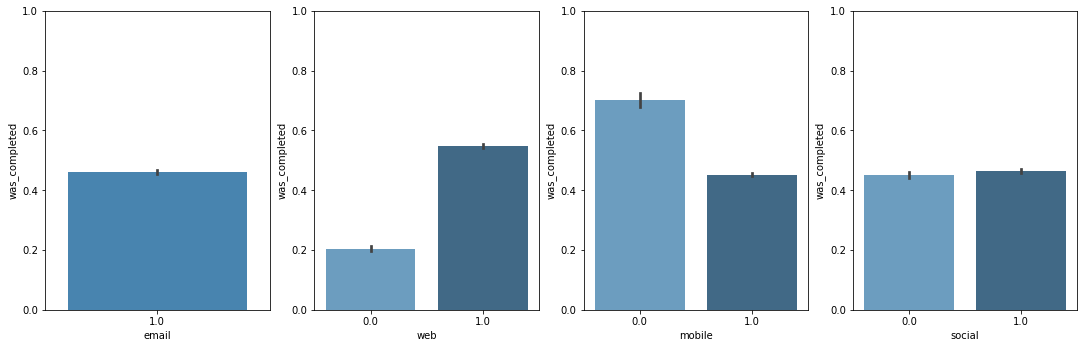

In [100]:
fig, axs = plt.subplots(1,4)
fig.set_size_inches(18.5, 5.5)
sns.barplot(ax=axs[0], x = analysis_df_t['email'], y = analysis_df_t['was_completed'], palette="Blues_d")
axs[0].set(ylim=(0,1))
sns.barplot(ax=axs[1], x = analysis_df_t['web'], y = analysis_df_t['was_completed'], palette="Blues_d")
axs[1].set(ylim=(0,1))
sns.barplot(ax=axs[2], x = analysis_df_t['mobile'], y = analysis_df_t['was_completed'], palette="Blues_d")
axs[2].set(ylim=(0,1))
sns.barplot(ax=axs[3], x = analysis_df_t['social'], y = analysis_df_t['was_completed'], palette="Blues_d")
axs[3].set(ylim=(0,1));

## Demographic descriptive Analysis and data cleaning due to missing data
As assessed prior to the data wrangling, there are customers with missing demographic information. In order to understand if this data is missing at random, the incremental spend for the group "missing data" versus "no missing data" is compared.

### Missing demographic information
The incremental spend for those with missing data is actually lower than for those with demographic data. The data is not missing at random. Potentially, at signup, users who are already more loyal or frequent customers are more inclined to give personal information to the company.
There is no good way to impute the data and hence the records will still be dropped. 

Another way to handle missing data is to code missing data as a legitimate characteristic and use it as a predictor. This will not be done for this analysis as some of the demographics are continuous variables, whereas "missing data" would be categorical. However, when the company sends out offers in the future, the mere presence of demographic data should already be taken as an indicator for higher incremental spend.

In [37]:
analysis_df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42571 entries, 17000 to 66446
Data columns (total 41 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              42571 non-null  int64  
 1   person                                  42571 non-null  object 
 2   block_id                                42571 non-null  object 
 3   hour                                    42571 non-null  float64
 4   amount                                  42571 non-null  float64
 5   hourly_avg                              42571 non-null  float64
 6   group                                   42571 non-null  object 
 7   baseline_spend_during_awareness_time    42571 non-null  float64
 8   incremental_spend                       42571 non-null  float64
 9   hourly_avg_during_nonawareness          42571 non-null  float64
 10  event_offer_id                          42571 non-null

In [38]:
analysis_df_t['missing_demogs'] = 'not missing'
analysis_df_t.loc[analysis_df_t['age'].isna(), 'missing_demogs'] = 'missing'

In [39]:
# Check number of records with missing values
analysis_df_t['missing_demogs'].value_counts()

not missing    35979
missing         6592
Name: missing_demogs, dtype: int64

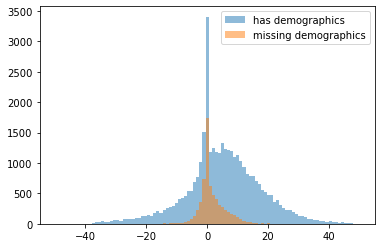

In [40]:
# Examine distributions
demog = analysis_df_t.loc[analysis_df_t['missing_demogs'] == 'not missing']['incremental_spend']
missing_demog = analysis_df_t.loc[analysis_df_t['missing_demogs'] == 'missing']['incremental_spend']

bins = np.linspace(-50,50,100)

plt.hist(demog, bins, alpha= 0.5, label = "has demographics")
plt.hist(missing_demog, bins, alpha= 0.5, label = "missing demographics")
plt.legend(loc = 'upper right')
plt.show()

In [41]:
# Check mean and median spend
analysis_df_t[['missing_demogs','incremental_spend']].groupby(['missing_demogs']).agg({'incremental_spend':[np.mean, np.median]})

incremental_spend          
                            mean    median
missing_demogs                            
missing                 1.750990  0.355636
not missing             5.168997  4.570000

In [42]:
# test if medians are statistically signifcantly different
demog = make_array(demog)
missing_demog = make_array(missing_demog)
statistic, pvalue = stats.mannwhitneyu(demog, missing_demog)
print("p-value: ",pvalue)

p-value:  5.670583761936881e-197


In [43]:
# Clean dataset
analysis_df_t = analysis_df_t.loc[analysis_df_t['missing_demogs'] == 'not missing']

### Demographic analysis

#### categorical variable
Females show a higher incremental spend than males. The customers who chose "Other" have a mean incremental spend tat is a bit higher than that of the males. However, as there are only few customers, the confidence interval (see black gar) is wide.

In [73]:
analysis_df_t[['gender','incremental_spend']].groupby(['gender']).agg({'incremental_spend':[np.mean, np.median, np.size]})

incremental_spend                   
                    mean    median     size
gender                                     
F               6.084897  6.090581  14417.0
M               4.546816  3.807713  21003.0
O               4.924140  4.787869    559.0

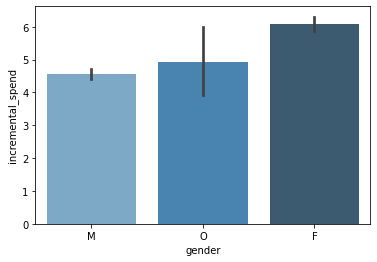

In [71]:
sns.barplot(x = analysis_df_t['gender'], y = analysis_df_t['incremental_spend'], palette="Blues_d");

#### continuous variables
The correlation with age is minimal. There is a very low positive correlation with income, where a higher income is associated with higher incremental spend. The strongest, albeit still weak relationship exists with membership duration. The longer someone has been a member, the higher the incremental spend. Visually in the scatterplots, these relationships are not visible at all.

In [53]:
analysis_df_t[['age','income','membership_duration']].nunique()

age                      84
income                   91
membership_duration    1702
dtype: int64

In [51]:
# correlation
analysis_df_t[['age','income','membership_duration','incremental_spend']].corr()

,age,income,membership_duration,incremental_spend
age,1.000000,0.286271,-0.007304,0.034356
income,0.286271,1.000000,-0.006320,0.110065
membership_duration,-0.007304,-0.006320,1.000000,-0.148675
incremental_spend,0.034356,0.110065,-0.148675,1.000000


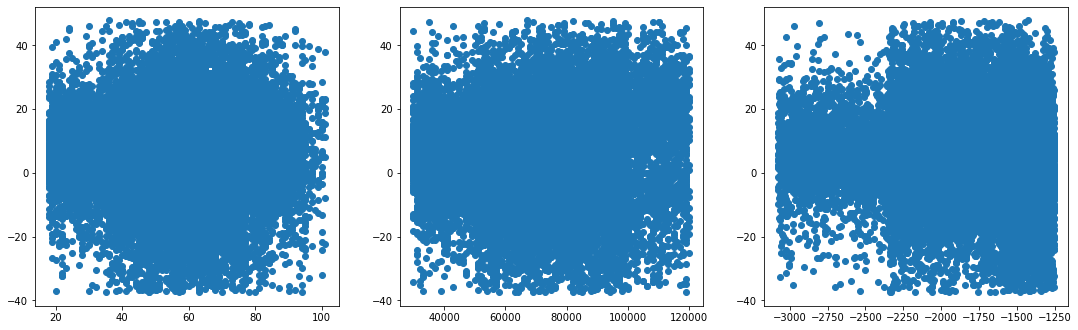

In [63]:
# Scatter plots
fig, axs = plt.subplots(1,3)
fig.set_size_inches(18.5, 5.5)
ax_age = axs[0].scatter(x=analysis_df_t['age'], y=analysis_df_t['incremental_spend'])
ax_income = axs[1].scatter(x=analysis_df_t['income'], y=analysis_df_t['incremental_spend'])
ax_mduration = axs[2].scatter(x=analysis_df_t['membership_duration'], y=analysis_df_t['incremental_spend']);

## Predictive Modelling

Variables to consider:

**Demographics:**
* gender
* membership duration
* income
* EXCLUDING: age, as the correlation shows no relationship

**Offer type and attributes:**
* offer_descriptor (same as event_offer_id)
* EXCLUDING: Attributes, as there would be a problem of multicollinearity. There are too few combinations of attributes, meaning for instance that a reward of 10 is *always* a BOGO; a difficulty of 20 is *always* one specific discount; a short duration is *always* an informational offer. One could exclude the type of offer to reduce the problem. However, from previous analysis it seems that the offer type  is a relevant variable. By using the offer_descriptor, i.e. all 10 offers, at least some information on the attributes is retained.

**Derived metrics**
* EXCLUDING: hourly_avg_during_nonawareness, as there is no relationship >> Check this is the right variable
* POTENTIAL: has completed offer before (maybe number of offers)
* POTENTIAL: was aware of offer before (maybe number of offers)
* POTENTIAL: time the offer was viewed (can be time of day or weather or if it was a weekend)

Overall, none of the independent variables seems to be a very strong predictor for incremental spend. Hence, a high R-squared is not expected.

### Creating more derived variables

In [201]:
# number of offers completed before
analysis_df_t[['person','block_id','hour','offer received','was_completed','offer_valid_until','offer viewed','offer completed','offer_aware_of_before','offers_completed_before']].sort_values(by=['person'])

,person,block_id,hour,offer received,was_completed,offer_valid_until,offer viewed,offer completed,offer_aware_of_before,offers_completed_before
0,0009655768c64bdeb2e877511632db8f,2,49.0,168.0,0.0,240.0,192.0,NaN,0.0,NaN
1,0009655768c64bdeb2e877511632db8f,1,61.0,336.0,0.0,432.0,372.0,NaN,1.0,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,9,91.0,0.0,0.0,96.0,6.0,NaN,0.0,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,8,67.0,168.0,1.0,336.0,186.0,252.0,1.0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,10,55.0,336.0,0.0,408.0,354.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...
35973,fffad4f4828548d1b5583907f2e9906b,76614,31.0,0.0,1.0,120.0,6.0,36.0,0.0,0.0
35975,fffad4f4828548d1b5583907f2e9906b,76615,7.0,408.0,1.0,528.0,510.0,516.0,2.0,1.0
35977,ffff82501cea40309d5fdd7edcca4a07,76616,25.0,168.0,1.0,408.0,174.0,198.0,1.0,1.0
35976,ffff82501cea40309d5fdd7edcca4a07,76621,55.0,0.0,1.0,240.0,6.0,60.0,0.0,0.0


##### number of offers aware of before

In [183]:
# number of offers aware before
# Source: dfriends.com by Dan Friedman, April 15, 2019: https://dfrieds.com/data-analysis/rank-method-python-pandas.html
analysis_df_t['offer_aware_of_before'] = analysis_df_t.groupby(['person'])['offer viewed'].rank(method = 'dense')-1

##### number of offers completed before

In [198]:
# For all offers that were completed, assess how many offers were completed before
completed_subset = analysis_df_t.loc[analysis_df_t['was_completed'] == 1]
completed_subset['offers_completed_before'] = analysis_df_t.groupby(['person'])['offer completed'].rank(method = 'dense')-1
completed_subset = completed_subset[['block_id','offers_completed_before']]

C:\Users\j\Python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [199]:
# Add this information to the analysis dataframe - need to fill in missing values for offers that were not completed
analysis_df_t = pd.merge(analysis_df_t,completed_subset,how = 'left', right_on = 'block_id', left_on = 'block_id')

In [200]:
# Sort dataframe so that offers appear in logical time-based order
analysis_df_t = analysis_df_t.sort_values(by=['person','offer viewed'], ascending = True)

In [237]:
# create list of all person ids
all_people = analysis_df_t['person'].drop_duplicates().tolist()

In [257]:
# Allocate correct number of "offers completed before" to every block_id that was not completed itself; need to loop through 'person' to do so
# Source Stackoverflow for dict-zip: https://stackoverflow.com/questions/18012505/python-pandas-dataframe-columns-convert-to-dict-key-and-value
# Question by perigee: https://stackoverflow.com/users/857130/perigee
# Answer by punchagan: https://stackoverflow.com/users/1225068/punchagan
offers_completed_before_dict = dict()
for person in all_people:
    df = analysis_df_t.loc[analysis_df_t['person'] == person]
    df = df.sort_values(by=['person','offer viewed'], ascending = True)
    df['offers_completed_before'] = df['offers_completed_before'].fillna(method = 'backfill')
    try:
        max_was_completed = df['was_completed'].sum()
    except:
        max_was_completed = 0
    df['offers_completed_before'] = df['offers_completed_before'].fillna(max_was_completed)
    dictionary = dict(zip(df.block_id,df.offers_completed_before))
    offers_completed_before_dict.update(dictionary)

In [264]:
# Add to analysis dataframe
analysis_df_t['offers_completed_before'] = analysis_df_t['block_id'].map(offers_completed_before_dict)

In [267]:
# Check that there are no missing values
analysis_df_t['offers_completed_before'].isna().sum()

0

### Recoding categorical variables into dummy variables

In [ ]:
# Dummy coding the gender
analysis_df_t = pd.merge(analysis_df_t,pd.get_dummies(analysis_df_t['gender']), left_index = True, right_index = True)

In [108]:
# Dummy coding the offer
analysis_df_t = pd.merge(analysis_df_t,pd.get_dummies(analysis_df_t['offer_descriptor']), left_index = True, right_index = True)

### Examining derived variables
**Avg. hourly spend during non-awareness:** The odd shape to the left of the graph appears because those with hourly spend 0 during non-awareness cannot possible have a negative incremental spend. There is no relationship between this variable and incremental spend.

**Number of offers customer was aware of before:** From the barchart, it seems that having been aware of one offer before is associated with higher incremental spend. There could be a "novelty effect" where the incremental spend actually decreases the more offers people were aware of. However, the correlation only shows a very weak relationship between the variables.

**Number of offers completed before:** Similar to the awareness, there seems to be a "novelty effect", but only a very weak correlation.

To incorporate the "novelty effect" into the analysis, the two latter variables are recoded into categorical variables that will be used as dummies, with categories "no previous offer", "one previous offer", "more than one previous offer".

##### Average hourly spend during non-awareness

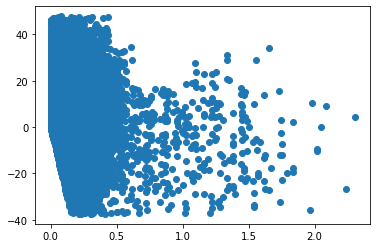

In [111]:
plt.scatter(x=analysis_df_t['hourly_avg_during_nonawareness'], y=analysis_df_t['incremental_spend']);

In [112]:
analysis_df_t[['hourly_avg_during_nonawareness','incremental_spend']].corr()

,hourly_avg_during_nonawareness,incremental_spend
hourly_avg_during_nonawareness,1.000000,-0.038221
incremental_spend,-0.038221,1.000000


##### Number of offers customer was aware of before

In [202]:
analysis_df_t[['offer_aware_of_before','incremental_spend']].corr()

,offer_aware_of_before,incremental_spend
offer_aware_of_before,1.00000,-0.02123
incremental_spend,-0.02123,1.00000


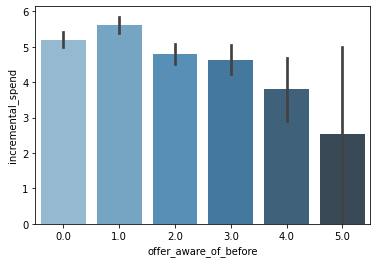

In [203]:
sns.barplot(x = analysis_df_t['offer_aware_of_before'], y = analysis_df_t['incremental_spend'], palette="Blues_d");

##### Number of offers completed before

In [268]:
analysis_df_t[['offers_completed_before','incremental_spend']].corr()

,offers_completed_before,incremental_spend
offers_completed_before,1.000000,0.057422
incremental_spend,0.057422,1.000000


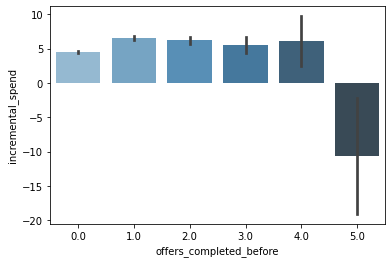

In [269]:
sns.barplot(x = analysis_df_t['offers_completed_before'], y = analysis_df_t['incremental_spend'], palette="Blues_d");

##### Recoding number of offer aware before and number of offers completed before

In [270]:
# Directly coding dummies
analysis_df_t['aware_before_0'] = 0
analysis_df_t.loc[analysis_df_t['offer_aware_of_before'] == 0,'aware_before_0'] = 1
analysis_df_t['aware_before_1'] = 0
analysis_df_t.loc[analysis_df_t['offer_aware_of_before'] == 1,'aware_before_1'] = 1

analysis_df_t['completed_before_0'] = 0
analysis_df_t.loc[analysis_df_t['offers_completed_before'] == 0,'completed_before_0'] = 1
analysis_df_t['completed_before_1'] = 0
analysis_df_t.loc[analysis_df_t['offers_completed_before'] == 1,'completed_before_1'] = 1

### Standardization of continuous variables

In [272]:
mean_income = analysis_df_t['income'].mean()
std_income = analysis_df_t['income'].std()
analysis_df_t['income_standardised'] = (analysis_df_t['income'] - mean_income)/std_income

In [273]:
mean_membership_duration = analysis_df_t['membership_duration'].mean()
std_membership_duration = analysis_df_t['membership_duration'].std()
analysis_df_t['membership_duration_standardised'] = (analysis_df_t['membership_duration'] - mean_membership_duration)/std_membership_duration

### Training the model and predicting
* multiple linear regression
* ridge regression to help select only importnat features
* lasso regression
> I do not really have the problem of having too many input variables, if anything I don't have enough

In [121]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#### Simple multiple regression model
a simple multiple regression model leads to a very poor R-squared of 0.04.

Good article: https://towardsdatascience.com/understanding-multiple-regression-249b16bde83e#:~:text=Multiple%20regression%20is%20an%20extension,of%20a%20different%20physical%20parameter.

In [276]:
# Source w3 schools: https://www.w3schools.com/python/python_ml_multiple_regression.asp
# Source (need to cite): for using training and testing: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
# Interesting: https://statisticsbyjim.com/regression/identifying-important-independent-variables/
# Separate input features from target
y = analysis_df_t[['incremental_spend']]
X = analysis_df_t[['income_standardised',
                   'membership_duration_standardised',
                   'F',
                   'M',
                   'bogo_10_10_3',
                   'bogo_10_10_4',
                   'bogo_5_5_3',
                   'bogo_5_5_4',
                   'disc_10_2_3',
                   'disc_10_2_4',
                   'disc_20_5_2',
                   'disc_7_3_4',
                   'info_0_0_2',
                   'aware_before_0',
                   'aware_before_1',
                   'completed_before_0',
                   'completed_before_1'
                  ]]

# Set up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)

# Train the model
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)

# Predict
y_pred = regr.predict(X_test)

# Evaluate
print("Coefficients: \n", regr.coef_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("R-squared: %.2f" % r2_score(y_test, y_pred))
print("Intercept: ", regr.intercept_)

Coefficients: 
 [[ 1.19661451 -1.65574292  0.87427836 -0.0421547   3.18331248  2.4017546
   1.34990891  1.50578041  2.06013694  3.74858539  5.66579858  2.47130377
   0.99272491  1.51647053  1.18099026 -2.67437505 -0.71443981]]
Mean squared error: 145.27
R-squared: 0.05
Intercept:  [3.71656554]


In [ ]:
# Residual plots to assess if a linear model is appropriate: https://towardsdatascience.com/simple-and-multiple-linear-regression-with-python-c9ab422ec29c



# Steps to improve:

* Check if it is easier to predict completion
* Check the residual plot and see if maybe a non-linear model is needed
* Use a different model, e.g. deep learning: https://www.researchgate.net/post/Low_R-squared; https://stats.stackexchange.com/questions/450182/does-machine-learning-offer-alternatives-to-linear-regression-i-e-ols-for-pr;
https://www.jigsawacademy.com/popular-regression-algorithms-ml/

In [134]:
analysis_df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35979 entries, 17000 to 66446
Data columns (total 55 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              35979 non-null  int64  
 1   person                                  35979 non-null  object 
 2   block_id                                35979 non-null  object 
 3   hour                                    35979 non-null  float64
 4   amount                                  35979 non-null  float64
 5   hourly_avg                              35979 non-null  float64
 6   group                                   35979 non-null  object 
 7   baseline_spend_during_awareness_time    35979 non-null  float64
 8   incremental_spend                       35979 non-null  float64
 9   hourly_avg_during_nonawareness          35979 non-null  float64
 10  event_offer_id                          35979 non-null